#comparison

Here's a comparison between k-means++ and k-median clustering algorithms based on the provided datasets:

**Aggregation Dataset:**

Time: k-means++ took less time (1.34 s) compared to k-median (1.42 s).

Purity: k-means++ achieved higher purity (0.908) compared to k-median (0.885).

**D31 Dataset:**

Time: k-means++ took more time (22.5 s) compared to k-median (11.6 s).

Purity: k-means++ achieved higher purity (0.944) compared to k-median (0.814).

**R15 Dataset:**

Time: k-means++ took less time (1.54 s) compared to k-median (1.98 s).

Purity: k-means++ achieved higher purity (0.926) compared to k-median (0.86).

**Iris Dataset:**

Time: k-means++ took less time (44.3 ms) compared to k-median (47.7 ms).

Purity: k-means++ achieved slightly higher purity (0.893) compared to k-median (0.887).

**Glass Dataset:**

Time: k-means++ took less time (131 ms) compared to k-median (220 ms).

Purity: k-means++ achieved slightly higher purity (0.53) compared to k-median (0.523).


#imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sys
from collections import Counter
from functools import reduce
import warnings
warnings.filterwarnings("ignore")

In [20]:
Aggregation = pd.read_csv("/content/Aggregation.data", sep='\t', header=None)
Aggregation.columns = ['Column1', 'Column2', 'label']

D31 = pd.read_csv("/content/D31.data", sep='\t', header=None)
D31.columns = ['Column1', 'Column2', 'label']

R15 = pd.read_csv("/content/R15.data", sep='\t', header=None)
R15.columns = ['Column1', 'Column2', 'label']

glass = pd.read_csv("/content/glass.data", header=None)
glass.columns = ['index', 'Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9', 'label']
glass.drop('index', axis= 1, inplace=True)

iris = pd.read_csv("/content/iris.data", header=None)
iris.columns = ['Column1', 'Column2', 'Column3', 'Column4', 'label']

#purity function

In [21]:
def purity(y_clust, y_class):
  size_clust = np.max(y_clust)+1
  len_clust = len(y_clust)
  clusters_labels = [None] * size_clust
  for i in range(len_clust):
        index = y_clust[i]
        if clusters_labels[index] is None:
            clusters_labels[index] = y_class[i]
        else:
            clusters_labels[index] = np.hstack((clusters_labels[index], y_class[i]))
  purity = 0
  for c in clusters_labels:
        y = np.bincount(c)
        maximum = np.max(y)
        purity += maximum

  purity = purity/len_clust

  return purity

#plot funtion

In [22]:
def plot(K, data, algorithm, idx):
  plt.figure(figsize=(10, 8))
  cmap = plt.get_cmap('tab20', K)  # Use 'tab20' colormap for up to 20 distinct colors

  for i in range(K):
      cluster_points = data.values[idx == i]
      plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=cmap(i), label=f'Cluster {i}')

  plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=100, label='Centroids')
  plt.xlabel('Principal Component 1')
  plt.ylabel('Principal Component 2')
  plt.title(f'{algorithm} Clustering Results')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

#kmeans++

##Algorithm

In [23]:
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))


def initialize_plusPlus(data, k):
    '''
    initialized the centroids for K-means++
    inputs:
        data - numpy array
        k - number of clusters
    '''
    # initialize the centroids list and add
    # a randomly selected data point to the list
    random.seed(42)
    np.random.seed(42)
    centroids = []
    centroids.append(random.choice(data))

    # compute remaining k - 1 centroids
    for c_id in range(k - 1):

        # initialize a list to store distances of data
        # points from nearest centroid
        dist = []
        for i in range(data.shape[0]):
            point = data[i, :]
            d = sys.maxsize

            # compute distance of 'point' from each of the previously
            # selected centroid and store the minimum distance
            for j in range(len(centroids)):
                temp_dist = distance(point, centroids[j])
                d = min(d, temp_dist)
            dist.append(d)

        # select data point with maximum distance as our next centroid
        dist = np.array(dist)
        next_centroid = data[np.argmax(dist), :]
        centroids.append(next_centroid)
        dist = []
    return centroids


def find_closest_centroids(X, centroids):
    global sumdistance
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distance = []
        for j in range(len(centroids)):
            norm_ij = np.linalg.norm(X[i] - centroids[j])
            distance.append(norm_ij)
            sumdistance = sum(distance)
        idx[i] = np.argmin(distance)
    return idx


def compute_centroids(X, idx, K):
    m, n = X.shape
    centroids = np.zeros((K, n))

    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.mean(points, axis = 0)

    return centroids


def run_kMeans(X, initial_centroids, n_cluster, max_iters=10):
    global sumdistance
    m = X.shape[0]
    K = n_cluster
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)


    # Run K-Means
    for i in range(max_iters):

        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))

        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X, centroids)
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X, idx, K)

        centroid_difference = np.linalg.norm(centroids - previous_centroids)

        if centroid_difference < 0.001:
            print("Converged at iteration", i)
            break
        previous_centroids = centroids.copy()
    return centroids, idx

##Aggregation dataset

In [24]:
%%time
n_cluster = 7
initial_centroids = np.array(initialize_plusPlus(Aggregation[['Column1', 'Column2']].values, n_cluster))
centroids, idx = run_kMeans(Aggregation[['Column1', 'Column2']].values , initial_centroids, n_cluster)

print(f"the purity of this clustering is {purity(idx, Aggregation[['label']].values)}")
plot(n_cluster, Aggregation, 'kmeans++',idx)

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
the purity of this clustering is 0.9086294416243654


CPU times: user 1.27 s, sys: 107 ms, total: 1.38 s
Wall time: 1.34 s


##D31 dataset

In [25]:
%%time
n_cluster = 31
initial_centroids = np.array(initialize_plusPlus(D31[['Column1', 'Column2']].values, n_cluster))
centroids, idx = run_kMeans(D31[['Column1', 'Column2']].values , initial_centroids, n_cluster)

print(f"the purity of this clustering is {purity(idx, D31[['label']].values)}")
plot(n_cluster, D31, 'kmeans++',idx)

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
the purity of this clustering is 0.9441935483870968


CPU times: user 21.7 s, sys: 423 ms, total: 22.1 s
Wall time: 22.5 s


##R15 dataset

In [26]:
%%time
n_cluster = 15
initial_centroids = np.array(initialize_plusPlus(R15[['Column1', 'Column2']].values, n_cluster))
centroids, idx = run_kMeans(R15[['Column1', 'Column2']].values , initial_centroids, n_cluster)

print(f"the purity of this clustering is {purity(idx, R15[['label']].values)}")
plot(n_cluster, R15, 'kmeans++', idx)

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
Converged at iteration 2
the purity of this clustering is 0.9266666666666666


CPU times: user 1.47 s, sys: 149 ms, total: 1.62 s
Wall time: 1.54 s


##iris dataset

In [27]:
%%time
n_cluster = 3
initial_centroids = np.array(initialize_plusPlus(iris[['Column1', 'Column2', 'Column3', 'Column4']].values, n_cluster))
centroids, idx = run_kMeans(iris[['Column1', 'Column2', 'Column3', 'Column4']].values , initial_centroids, n_cluster)

label_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
iris['label'] = iris['label'].map(label_mapping)

print(f"the purity of this clustering is {purity(idx, iris[['label']].values)}")

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
Converged at iteration 3
the purity of this clustering is 0.8933333333333333
CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 44.3 ms


##glass dataset

In [28]:
%%time
n_cluster = 6
initial_centroids = np.array(initialize_plusPlus(glass[['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9']].values, n_cluster))
centroids, idx = run_kMeans(glass[['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9']].values , initial_centroids, n_cluster)
print(f"the purity of this clustering is {purity(idx, glass[['label']].values)}")

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
Converged at iteration 6
the purity of this clustering is 0.5373831775700935
CPU times: user 124 ms, sys: 875 Âµs, total: 125 ms
Wall time: 131 ms


#k-median

##Algorithm

In [29]:
def kmedian_init_centroids(X, K):
    random.seed(42)
    np.random.seed(42)
    randidx = np.random.permutation(X.shape[0])

    centroids = X[randidx[:K]]
    return centroids

def find_closest_centroids_manhatan(X, centroids):
    global sumdistance
    idx = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        distance = []
        for j in range(len(centroids)):
            norm_ij = np.sum(np.abs(X[i] - centroids[j]))  # Manhattan distance calculation
            distance.append(norm_ij)
            sumdistance = sum(distance)
        idx[i] = np.argmin(distance)
    return idx

def compute_centroids_median(X, idx, K):
    m, n = X.shape
    centroids = np.zeros((K, n))

    for k in range(K):
        points = X[idx == k]
        centroids[k] = np.median(points, axis = 0)

    return centroids

def run_kmedian(X, initial_centroids, n_cluster, max_iters=10):
    global sumdistance
    m = X.shape[0]
    K = n_cluster
    centroids = initial_centroids
    previous_centroids = centroids
    idx = np.zeros(m)


    # Run K-median
    for i in range(max_iters):

        #Output progress
        print("k-median iteration %d/%d" % (i, max_iters-1))

        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids_manhatan(X, centroids)
        # Given the memberships, compute new centroids
        centroids = compute_centroids_median(X, idx, K)

        centroid_difference = np.linalg.norm(centroids - previous_centroids)

        if centroid_difference < 0.001:
            print("Converged at iteration", i)
            break
        previous_centroids = centroids.copy()
    return centroids, idx

##Aggregation dataset

k-median iteration 0/9
k-median iteration 1/9
k-median iteration 2/9
k-median iteration 3/9
k-median iteration 4/9
k-median iteration 5/9
k-median iteration 6/9
k-median iteration 7/9
k-median iteration 8/9
k-median iteration 9/9
the purity of this clustering is 0.8857868020304569


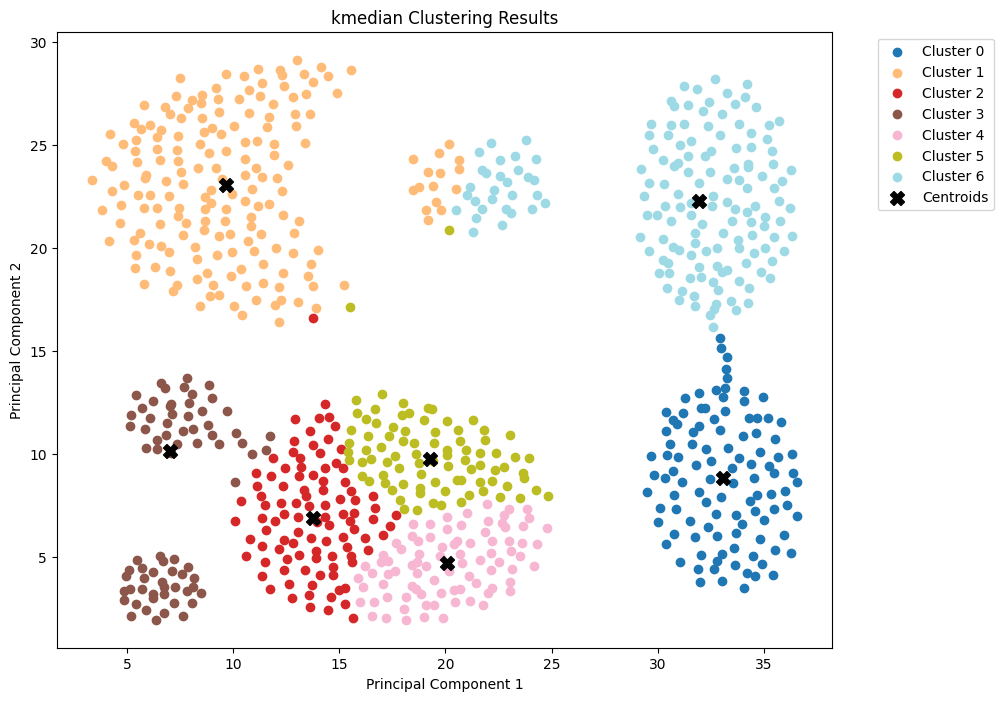

CPU times: user 1.31 s, sys: 164 ms, total: 1.47 s
Wall time: 1.42 s


In [30]:
%%time
n_cluster = 7
initial_centroids = np.array(kmedian_init_centroids(Aggregation[['Column1', 'Column2']].values, n_cluster))
centroids, idx = run_kmedian(Aggregation[['Column1', 'Column2']].values , initial_centroids, n_cluster)

print(f"the purity of this clustering is {purity(idx, Aggregation[['label']].values)}")
plot(n_cluster, Aggregation, 'kmedian', idx)

##D31 dataset

In [31]:
%%time
n_cluster = 31
initial_centroids = np.array(kmedian_init_centroids(D31[['Column1', 'Column2']].values, n_cluster))
centroids, idx = run_kmedian(D31[['Column1', 'Column2']].values , initial_centroids, n_cluster)

print(f"the purity of this clustering is {purity(idx, D31[['label']].values)}")
plot(n_cluster, D31, 'kmedian', idx)

k-median iteration 0/9
k-median iteration 1/9
k-median iteration 2/9
k-median iteration 3/9
k-median iteration 4/9
k-median iteration 5/9
k-median iteration 6/9
k-median iteration 7/9
k-median iteration 8/9
k-median iteration 9/9
the purity of this clustering is 0.8148387096774193


CPU times: user 11.1 s, sys: 382 ms, total: 11.4 s
Wall time: 11.6 s


##R15 dataset

In [32]:
%%time
n_cluster = 15
initial_centroids = np.array(kmedian_init_centroids(R15[['Column1', 'Column2']].values, n_cluster))
centroids, idx = run_kmedian(R15[['Column1', 'Column2']].values , initial_centroids, n_cluster)

print(f"the purity of this clustering is {purity(idx, R15[['label']].values)}")
plot(n_cluster, R15, 'kmedian', idx)

k-median iteration 0/9
k-median iteration 1/9
k-median iteration 2/9
k-median iteration 3/9
k-median iteration 4/9
k-median iteration 5/9
k-median iteration 6/9
k-median iteration 7/9
k-median iteration 8/9
k-median iteration 9/9
the purity of this clustering is 0.86


CPU times: user 1.85 s, sys: 189 ms, total: 2.04 s
Wall time: 1.98 s


##iris dataset

In [33]:
%%time
n_cluster = 3
initial_centroids = np.array(kmedian_init_centroids(iris[['Column1', 'Column2', 'Column3', 'Column4']].values, n_cluster))
centroids, idx = run_kmedian(iris[['Column1', 'Column2', 'Column3', 'Column4']].values , initial_centroids, n_cluster)
print(f"the purity of this clustering is {purity(idx, iris[['label']].values)}")

k-median iteration 0/9
k-median iteration 1/9
k-median iteration 2/9
k-median iteration 3/9
Converged at iteration 3
the purity of this clustering is 0.8866666666666667
CPU times: user 39.4 ms, sys: 1.01 ms, total: 40.4 ms
Wall time: 47.7 ms


##glass dataset

In [34]:
%%time
n_cluster = 6
initial_centroids = np.array(kmedian_init_centroids(glass[['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9']].values, n_cluster))
centroids, idx = run_kmedian(glass[['Col1', 'Col2', 'Col3', 'Col4', 'Col5', 'Col6', 'Col7', 'Col8', 'Col9']].values , initial_centroids, n_cluster)
print(f"the purity of this clustering is {purity(idx, glass[['label']].values)}")

k-median iteration 0/9
k-median iteration 1/9
k-median iteration 2/9
k-median iteration 3/9
k-median iteration 4/9
k-median iteration 5/9
k-median iteration 6/9
k-median iteration 7/9
k-median iteration 8/9
k-median iteration 9/9
the purity of this clustering is 0.5233644859813084
CPU times: user 204 ms, sys: 13.4 ms, total: 218 ms
Wall time: 220 ms
